Purpose of this step: Develop a time-series forecasting model (LSTM) to predict future chamber temperature given historical data and auxiliary variables (pressure, external temp, power input).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load Preprocessed Data

In [2]:
df_scaled = pd.read_csv('cryogenic_chamber_data_scaled.csv', parse_dates=['timestamp'])
df_scaled.sort_values('timestamp', inplace=True)
df_scaled.reset_index(drop=True, inplace=True)

In [3]:
df_scaled.head()

,chamber_temp_K,chamber_pressure_bar,external_temp_K,power_input,timestamp
0,0.418478,0.062093,0.462116,0.356676,2025-01-01 00:00:00
1,0.422853,0.086940,0.516752,0.423619,2025-01-01 00:15:00
2,0.467534,0.060842,0.530646,0.380511,2025-01-01 00:30:00
3,0.514566,0.086827,0.565601,0.435110,2025-01-01 00:45:00
4,0.486461,0.027022,0.481195,0.481365,2025-01-01 01:00:00


In [4]:
feature_cols = ['chamber_temp_K', 'chamber_pressure_bar', 'external_temp_K', 'power_input']

In [5]:
print("Data shape:", df_scaled.shape)

Data shape: (2000, 5)


# Prepare Sequences for Time-Series

#### We'll try to predict the next time step's "chamber_temp_K" from the past X timesteps.

In [6]:
TIME_STEPS = 10   # how many past steps we consider
TARGET_COL = 'chamber_temp_K'

In [7]:
def create_sequences(data, time_steps=1, target_index=0):
    """Convert dataframe values into a 3D array: (samples, time_steps, features). 
       And a corresponding target array: (samples,)."""
    X = []
    y = []
    for i in range(len(data) - time_steps):
        seq_x = data[i:(i+time_steps)]
        seq_y = data[i+time_steps, target_index]  # target after 'time_steps'
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

values = df_scaled[feature_cols].values
X_all, y_all = create_sequences(values, time_steps=TIME_STEPS, 
                               target_index=feature_cols.index(TARGET_COL))

# train-test split
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1592, 10, 4)
X_test shape: (398, 10, 4)
y_train shape: (1592,)
y_test shape: (398,)


In [8]:
print(len(X_train[0]))
print(y_train[0])

10
0.6000259392033603


### Build LSTM Model

In [9]:
model = keras.Sequential([
    layers.Input(shape=(TIME_STEPS, len(feature_cols))),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)  # predicting the scaled temperature
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [10]:
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0914 - val_loss: 0.0117
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_loss: 0.0079
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - val_loss: 0.0028
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - val_lo

### Plotting Curves

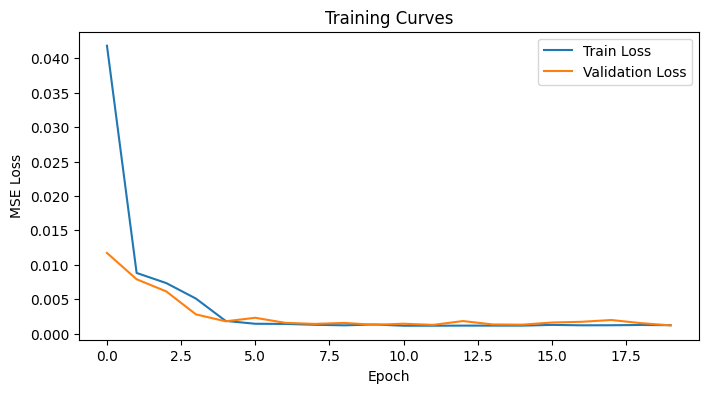

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Evaluate Model

In [12]:
'''
Remember y_pred is in scaled values. We need to invert the scaling for "chamber_temp_K" to interpret properly.

We'll reconstruct an array of zeros and place y_pred in correct col for inverse transform
'''

'\nRemember y_pred is in scaled values. We need to invert the scaling for "chamber_temp_K" to interpret properly.\n\nWe\'ll reconstruct an array of zeros and place y_pred in correct col for inverse transform\n'

In [13]:
y_pred = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [14]:
df_original = pd.read_csv('cryogenic_chamber_data.csv', parse_dates=['timestamp'])

In [15]:
df_scaled_ref = pd.read_csv('cryogenic_chamber_data_scaled.csv')
scaling_features = df_scaled_ref[feature_cols].values

In [16]:
scaler = MinMaxScaler()
scaler.fit(scaling_features)

MinMaxScaler()

In [17]:
'''
Placeholder for inversions. This is done because the scaler needs all features 
to perform the inverse transformation, even though we only care about the target
variable.. Hence we keep place the predicted and true values in the proper column, 
but keeping the rest as 0 (we don't care about these).
'''

n_features = len(feature_cols)
y_pred_full = np.zeros((len(y_pred), n_features))
y_true_full = np.zeros((len(y_test), n_features))


In [18]:
# put y_pred in the correct column
temp_idx = feature_cols.index(TARGET_COL)
y_pred_full[:, temp_idx] = y_pred.reshape(-1)
y_true_full[:, temp_idx] = y_test.reshape(-1)

In [19]:
temp_idx

0

In [20]:
# inverse transform
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, temp_idx]
y_true_inv = scaler.inverse_transform(y_true_full)[:, temp_idx]

In [21]:
mse = mean_squared_error(y_true_inv, y_pred_inv)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
rmse = np.sqrt(mse)

In [22]:
print("\nEvaluation on Test Set:")
print(f"RMSE: {rmse:.4f} K")
print(f"MSE:  {mse:.4f} K^2")
print(f"MAE:  {mae:.4f} K")


Evaluation on Test Set:
RMSE: 0.0346 K
MSE:  0.0012 K^2
MAE:  0.0273 K


### Plots

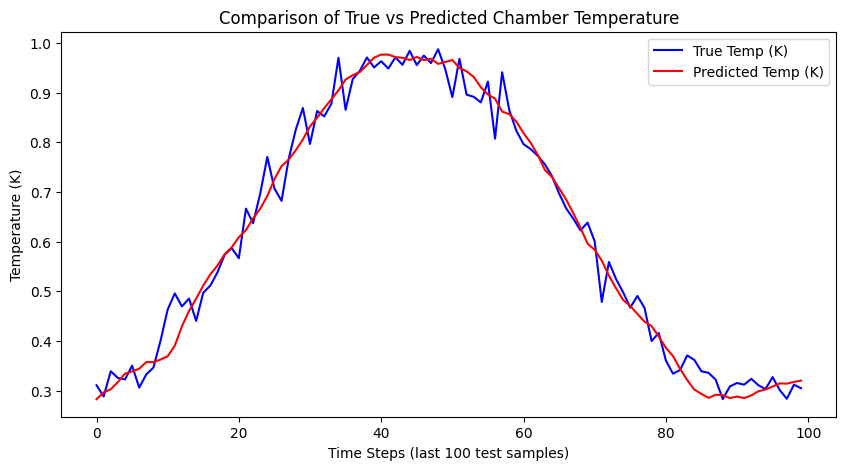

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(y_true_inv[-100:], label='True Temp (K)', color='blue')
plt.plot(y_pred_inv[-100:], label='Predicted Temp (K)', color='red')
plt.title('Comparison of True vs Predicted Chamber Temperature')
plt.xlabel('Time Steps (last 100 test samples)')
plt.ylabel('Temperature (K)')
plt.legend()
plt.show()

### Save Model

In [24]:
model.save('cryogenic_temp_predictor.h5')
print("\nModel saved as 'cryogenic_temp_predictor.h5'.")


Model saved as 'cryogenic_temp_predictor.h5'.
